In [2]:
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
confirmed_df = pd.read_csv("datasets/time_series_covid19_confirmed_global_modified.csv",sep=',')
tests_positive_df = pd.read_csv("datasets/covid-19-tests-vs-cases-positivity-comparisons.csv")
print("Tests positive shaped: ", tests_positive_df.shape)
print("Confirmed shape: ", confirmed_df.shape)

Tests positive shaped:  (14537, 5)
Confirmed shape:  (182, 96)


In [4]:
#Coveeting the string date into datetime pandas object
tests_positive_df['Date'] =  pd.to_datetime(tests_positive_df['Date'])

In [5]:
#Converting the date in dataframe to epoch. It would be easy to compare epoch times to make the data uniform 
#based on the starting and ending date
tests_positive_df['Date'] = (tests_positive_df['Date'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [6]:
#Converting into a timeseries dataframe
jp_tests_positive_df = tests_positive_df.pivot_table(values="Total confirmed cases of COVID-19 (cases)",index="Entity",columns="Date")

In [7]:
#Finding the columns with the same dates in both the dataframes
similar_columns_list_confirmed = []
for col in jp_tests_positive_df.columns:
    if str(col) in confirmed_df.columns:
        similar_columns_list_confirmed.append(col)

In [8]:
# Taking only the columns in with similar columns in both dataframes
jp_tests_positive_df = jp_tests_positive_df[similar_columns_list_confirmed]

similar_columns_list_confirmed = [str(i) for i in similar_columns_list_confirmed]
indexes = ['Country/Region','Country Code','Lat','Long']
lst = list(similar_columns_list_confirmed)
for i in lst:
    indexes.append(i)

final_confirmed_df = confirmed_df[indexes]

In [9]:
# Summing up the total positive cases across all the days
total_tests_positive_df = jp_tests_positive_df.sum(axis=1)
total_tests_positive_df = total_tests_positive_df.to_frame()
total_tests_positive_df.columns = ['Total Positives']

#was facing some problems in directly merging the dataframes as is due to column names not displaying as desired, so writing into a csv
total_tests_positive_df.to_csv("datasets/positives.csv")

#Summing up the total confirmed cases across all days 
final_confirmed_df['Total Confirmed'] = final_confirmed_df[lst].sum(axis=1)
total_confirmed_df = final_confirmed_df[['Country/Region','Country Code','Lat','Long','Total Confirmed']]

total_confirmed_df.head()

,Country/Region,Country Code,Lat,Long,Total Confirmed
0,Afghanistan,AFG,33.00,65.00,15197
1,Albania,ALB,41.15,20.17,12060
2,Algeria,DZA,28.03,1.66,46533
3,Andorra,AND,42.51,1.52,15989
4,Angola,AGO,-11.20,17.87,440


In [10]:
# Reading the earlier total positives dataset and renaming the columns according to merge into a single dataset having the total confirmed cases and total positives
#based on countries
final_positives_df = pd.read_csv('datasets/positives.csv')
final_positives_df.columns = ['Country/Region','Total Positives']

final_positives_df.head()

,Country/Region,Total Positives
0,Afghanistan,13417.0
1,Africa,342286.0
2,Albania,11433.0
3,Algeria,43575.0
4,Andorra,15314.0


In [11]:
#Final data set having aggregated confirmed and positive cases
final_df = pd.merge(total_confirmed_df,final_positives_df,on='Country/Region')
final_df.to_csv("datasets/aggregated_counts.csv")

final_df.head()

,Country/Region,Country Code,Lat,Long,Total Confirmed,Total Positives
0,Afghanistan,AFG,33.00,65.00,15197,13417.0
1,Albania,ALB,41.15,20.17,12060,11433.0
2,Algeria,DZA,28.03,1.66,46533,43575.0
3,Andorra,AND,42.51,1.52,15989,15314.0
4,Angola,AGO,-11.20,17.87,440,409.0


In [24]:
#Reading the data having the GDP per capita and population density
popdensity_gdp_df = pd.read_csv('datasets/gdp_per_capita_and_population_density.csv',usecols=['Country Name','GDP per capita (current US$)','Population density'])

In [25]:
popdensity_gdp_df.columns = ['Country/Region','GDP per capita','Population density']

In [26]:
#Combining the Total Confirmed and GDP per capita of different countries
confirmed_vs_gdp = pd.merge(final_df[['Country/Region','Country Code','Total Confirmed']],popdensity_gdp_df[['Country/Region','GDP per capita']],on='Country/Region')
confirmed_vs_gdp.head()

,Country/Region,Country Code,Total Confirmed,GDP per capita
0,Afghanistan,AFG,15197,637
1,Albania,ALB,12060,4413
2,Algeria,DZA,46533,5499
3,Andorra,AND,15989,40626
4,Angola,AGO,440,5254


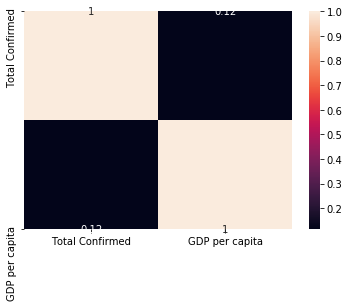

In [35]:
import seaborn as sns
gdp_correlation = confirmed_vs_gdp.corr()
sns.heatmap(gdp_correlation, xticklabels=gdp_correlation.columns, yticklabels=gdp_correlation.columns)

In [36]:
print(gdp_correlation)

                 Total Confirmed  GDP per capita
Total Confirmed         1.000000        0.115883
GDP per capita          0.115883        1.000000


In [30]:
#Combining the Total Confirmed and population density of different countries
confirmed_vs_pop_density = pd.merge(final_df[['Country/Region','Country Code','Total Confirmed']],popdensity_gdp_df[['Country/Region','Population density']],on='Country/Region')
confirmed_vs_pop_density.head()

,Country/Region,Country Code,Total Confirmed,Population density
0,Afghanistan,AFG,15197,49
1,Albania,ALB,12060,105
2,Algeria,DZA,46533,16
3,Andorra,AND,15989,171
4,Angola,AGO,440,20


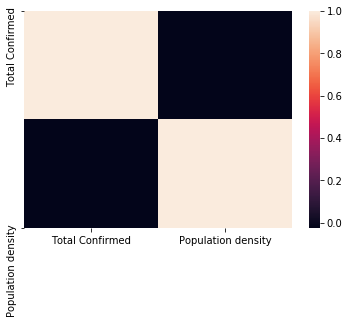

In [32]:
popdensity_correlation = confirmed_vs_pop_density.corr()
sns.heatmap(popdensity_correlation, xticklabels=popdensity_correlation.columns, yticklabels=popdensity_correlation.columns)

In [33]:
print(popdensity_correlation)

                    Total Confirmed  Population density
Total Confirmed            1.000000           -0.025748
Population density        -0.025748            1.000000


GDP per capita       NaN
Population density   NaN
Total Confirmed      NaN
Total Positives      NaN
dtype: float64

In [42]:
new_df = pd.merge(final_df[['Country/Region','Total Confirmed','Total Positives']],popdensity_gdp_df,on='Country/Region')


In [43]:
print(new_df.corr())

                    Total Confirmed  Total Positives  GDP per capita  \
Total Confirmed            1.000000         0.998481        0.115883   
Total Positives            0.998481         1.000000        0.107656   
GDP per capita             0.115883         0.107656        1.000000   
Population density        -0.025748        -0.025254        0.484073   

                    Population density  
Total Confirmed              -0.025748  
Total Positives              -0.025254  
GDP per capita                0.484073  
Population density            1.000000  
